# **Tutorial 3: Extreme Value Analysis - the GEV Distribution**

**Week 2, Day 4, Extremes & Vulnerability**

**Content creators:** Matthias Aengenheyster, Joeri Reinders

**Content reviewers:** Younkap Nina Duplex, Sloane Garelick, Zahra Khodakaramimaghsoud, Peter Ohue, Laura Paccini, Jenna Pearson, Agustina Pesce, Derick Temfack, Peizhen Yang, Cheng Zhang, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**

In the previous tutorial, we calculated **empirical return levels** as one method to determine return values. Another approach involves computing the probability of exceeding a certain threshold using a probability density function fitted to the data. For instance, in Tutorial 1, we used the normal distribution PDF. However, we observed that the normal distribution did not adequately fit our precipitation data.

By the end of this tutorial, you will gain the following skills:

- Creating a Quantile plot to assess the goodness-of-fit between a distribution and the data.
- Fitting a Generalized Extreme Value (GEV) distribution to the data.
- Understanding how the parameters of the GEV distribution influence its behavior.

# **Setup**

In [1]:
#install dependencies - taken from <Yosmely Bermúdez> comments for Tutorial 6
# We need this to install eigen which is needed for SDFC to install correctly
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install pandas
# !pip install cartopy
# !pip install scipy


In [2]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.stats import genextreme as gev
import os
import pooch

In [3]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

In [4]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

# **Section 1: Precipitation Data Histogram and Normal Distribution**
Let's repeat our first steps from tutorials 1 and 2: 
1) open the precipitation annual block maxima record, 
2) create a histogram of the data and plot the normal distribution probability density function.

In [5]:

# download file: 'precipitationGermany_1920-2022.csv'
url_precipitationGermany = "https://osf.io/xs7h6/download"


data = pd.read_csv(pooch.retrieve(url_precipitationGermany, known_hash=None),
                   index_col=0).set_index('years')
data.columns=['precipitation']
precipitation = data.precipitation

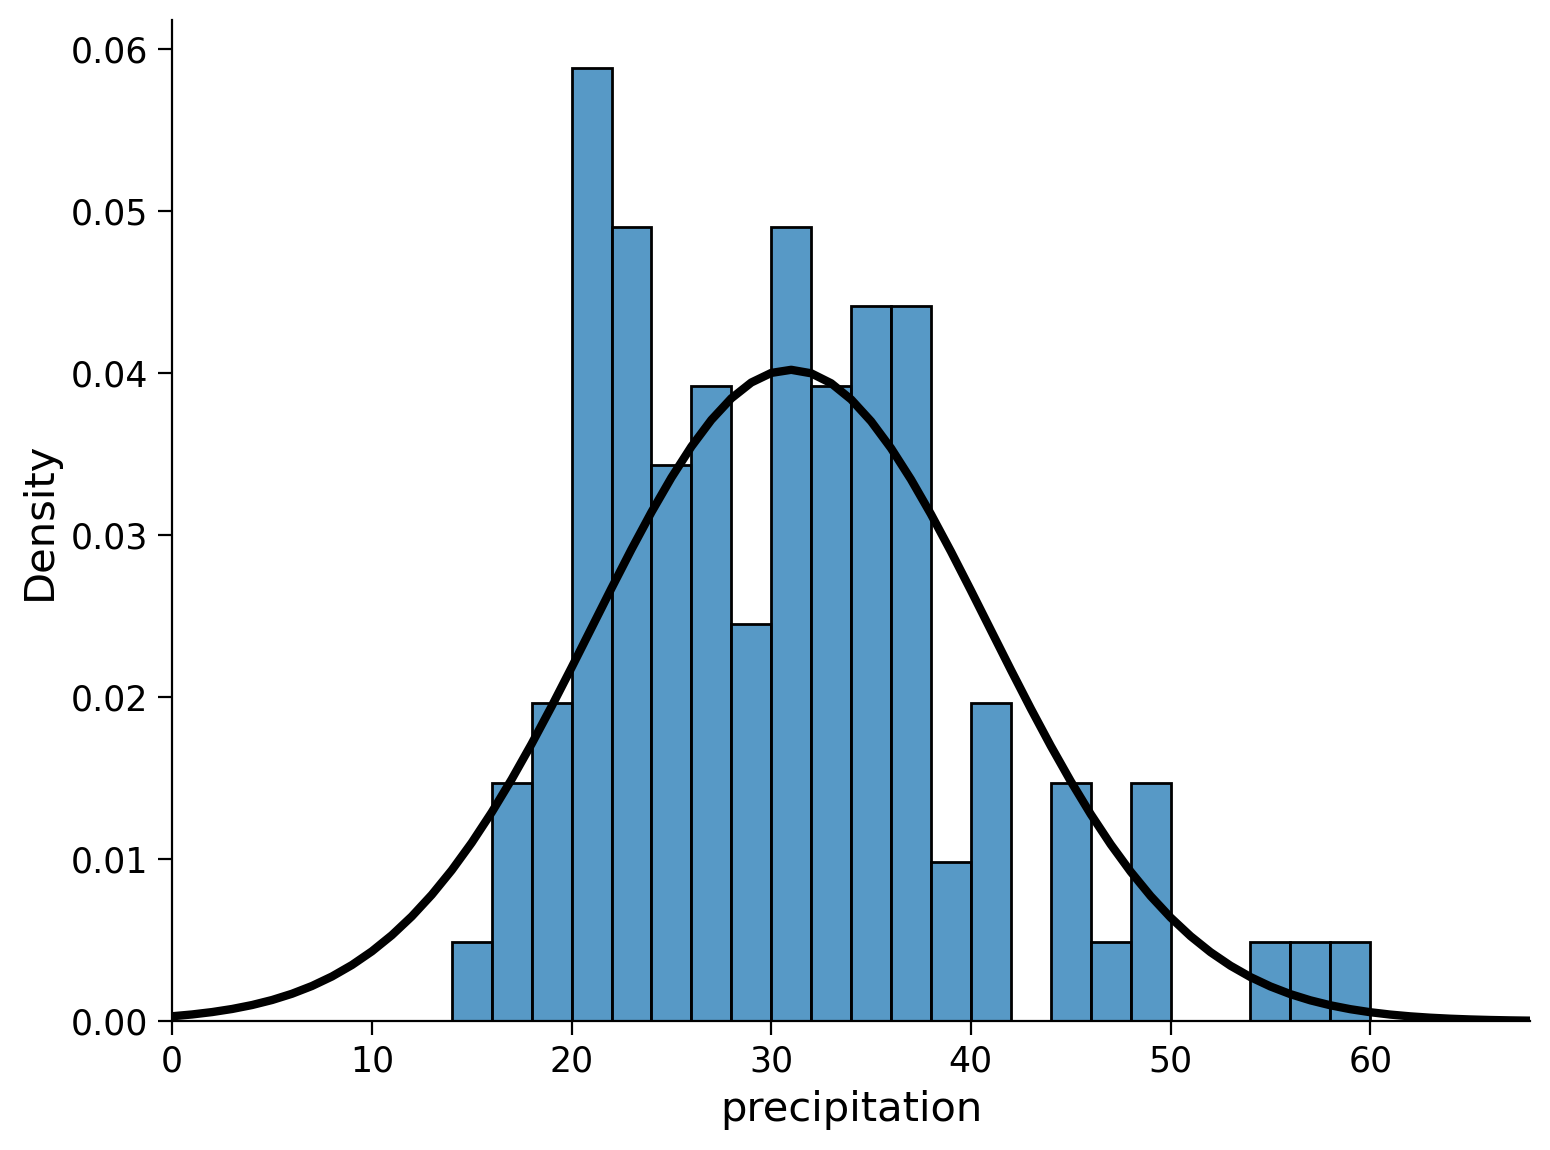

In [6]:
fig,ax=plt.subplots()
bins=np.arange(0,precipitation.max(),2)
sns.histplot(precipitation,bins=bins,stat='density',ax=ax)
ax.set_xlim(bins[0],bins[-1])

ylim = ax.get_ylim()

x_r100 = np.arange(0,100,1)
ax.plot(x_r100,stats.norm.pdf(x_r100,precipitation.mean(),precipitation.std()),c='k',lw=3)

Next, we generate Quantile plots (QQ plots) to assess how well our data aligns with a normal distribution. As mentioned in the lecture, a QQ plot compares the *actual* percentiles of the data to the *expected* percentiles based on a specific distribution, such as a normal distribution.

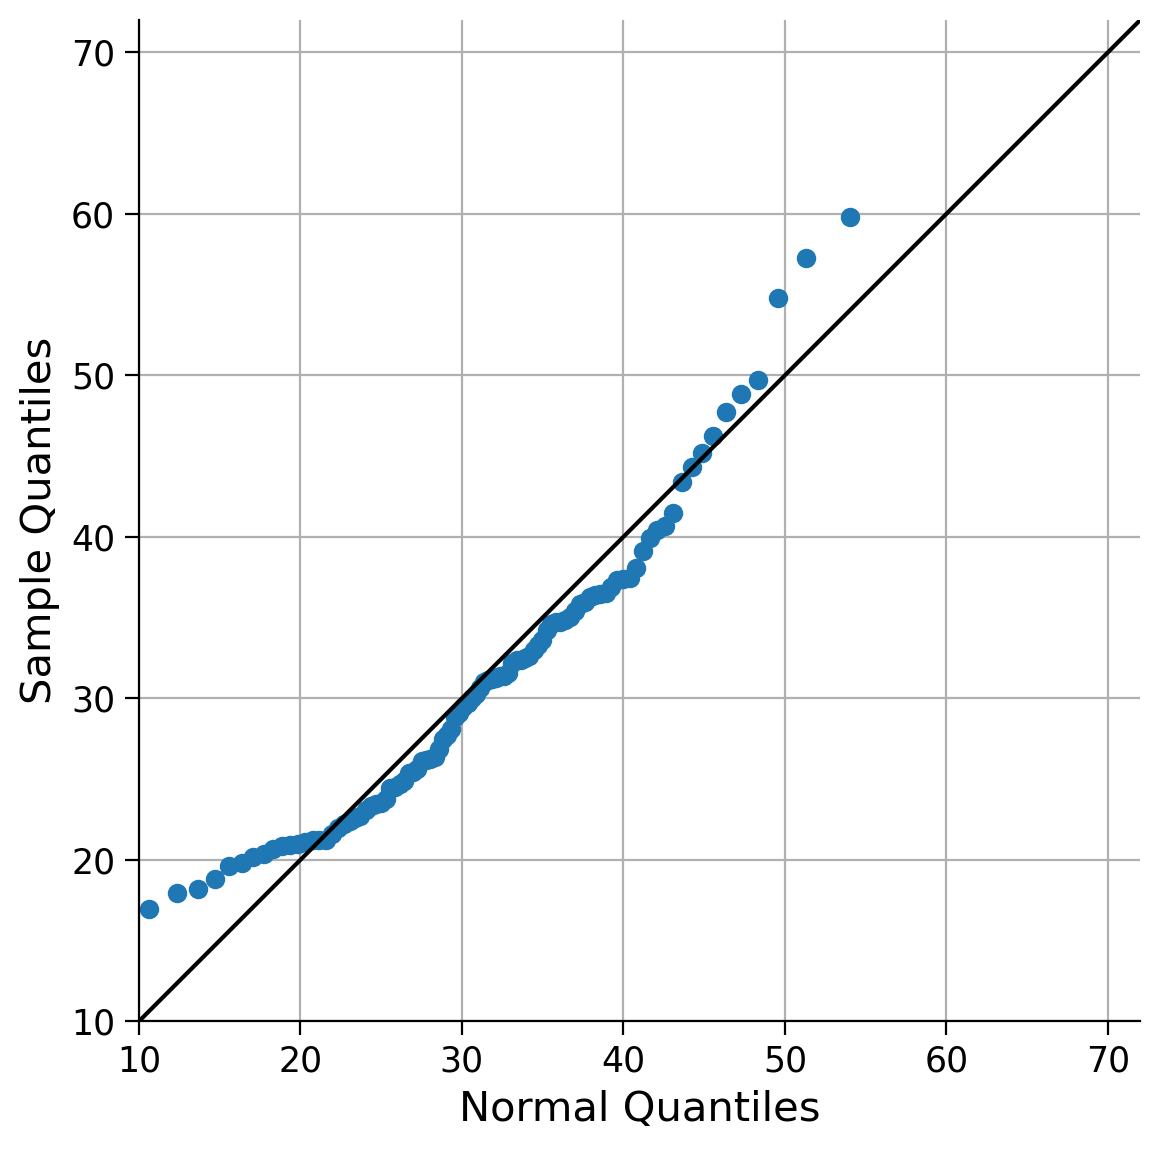

In [7]:
x_r1 = np.linspace(0,1,100)
fig,ax=plt.subplots()
ax.plot(
    stats.norm.ppf(x_r1,precipitation.mean(), precipitation.std()),
    np.quantile(precipitation,x_r1),
    'o')
ax.plot(x_r100,x_r100,'k')

ax.set_xlim(10,72)
ax.set_ylim(10,72)

ax.set_xlabel('Normal Quantiles')
ax.set_ylabel('Sample Quantiles')

ax.grid(True)
ax.set_aspect('equal')

Hopefully, you concur that the current fit could be improved, particularly when it comes to the extreme values, which appear to be both underestimated and overestimated by the normal distribution model. Therefore, let's explore alternative options, as there are numerous other distributions available. One example is the General Extreme Value (GEV) distribution.

The GEV distribution encompasses three parameters that define its shape: the location, scale, and shape parameters. To provide some context, the normal distribution only has two parameters: the mean and standard deviation. When the mean of the normal distribution is increased, it shifts the distribution towards higher values, while increasing the standard deviation makes the distribution wider. In contrast, the normal distribution is symmetrical, lacking a parameter that influences its skewness, which can pose challenges in certain scenarios.

In the GEV distribution, the location and scale parameters behave similarly to the mean and standard deviation in the normal distribution. The shape parameter impacts the tails of the distribution, making them thinner or thicker. As extreme event distributions often exhibit thick tails, they tend to possess slight skewness. Adjusting the shape parameter, therefore, influences the skewness (and kurtosis) of the data.

To estimate the parameters of the GEV distribution, we utilize the `scipy.stats.genextreme` function from the `scipy` package. Here we call this function `gev`. While the normal distribution only requires the mean and standard deviation as parameters, the GEV distribution requires three parameters (location, scale, and shape), which are interdependent and cannot be individually estimated. These parameters can be fitted to the data using by calling `gev.fit` with the data. The second argument is optional, it is the starting guess for the shape parameter. It sometimes makes sense to set this to zero as otherwise the fitting algorithm may be unstable and return incorrect values (hint: always check if your results are sensible!)

In [8]:
shape, loc, scale = gev.fit(precipitation.values,0)

In [9]:
shape,loc,scale

(-0.04713587000734158, 26.353581930592185, 7.369405343826601)

Let's generate another histogram of the data and overlay the Generalized Extreme Value (GEV) distribution with the fitted parameters.

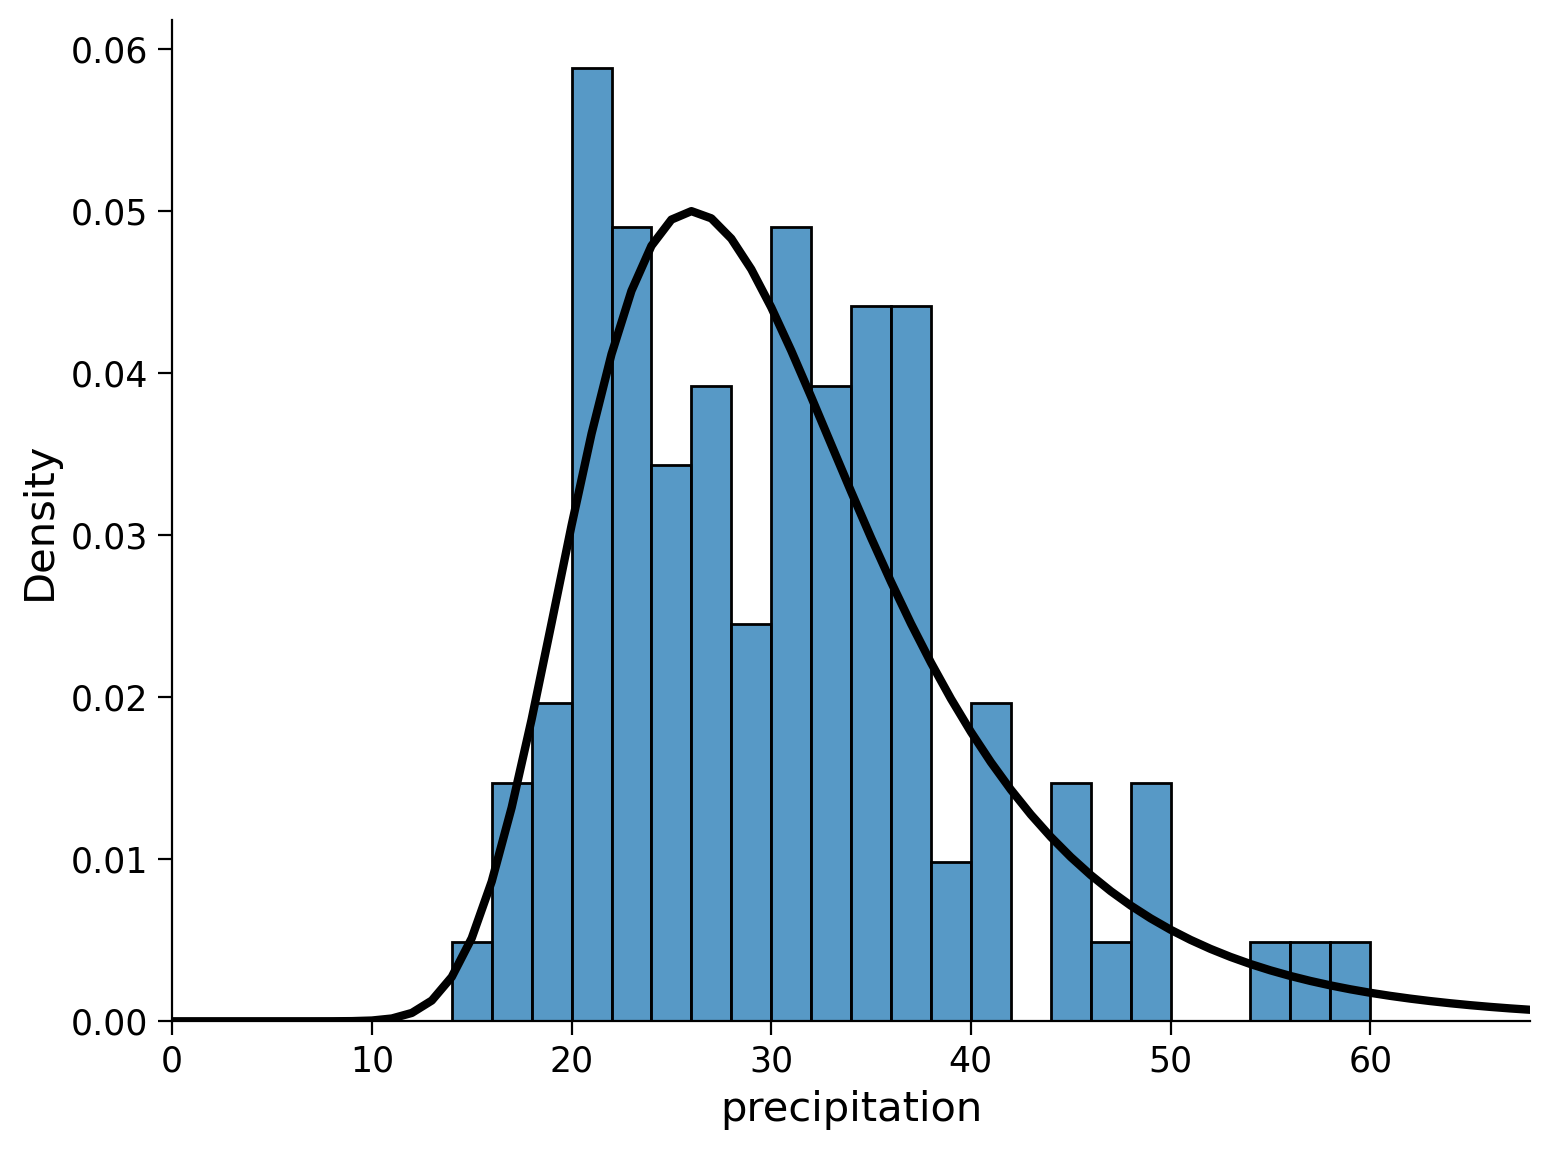

In [10]:
fig,ax=plt.subplots()
sns.histplot(precipitation,bins=bins,stat='density',ax=ax)
ax.set_xlim(bins[0],bins[-1])

x_r80 = np.arange(80)
ax.plot(x_r80,gev.pdf(x_r80, shape, loc=loc, scale=scale),'k',lw=3)

And also create a QQ-plot:

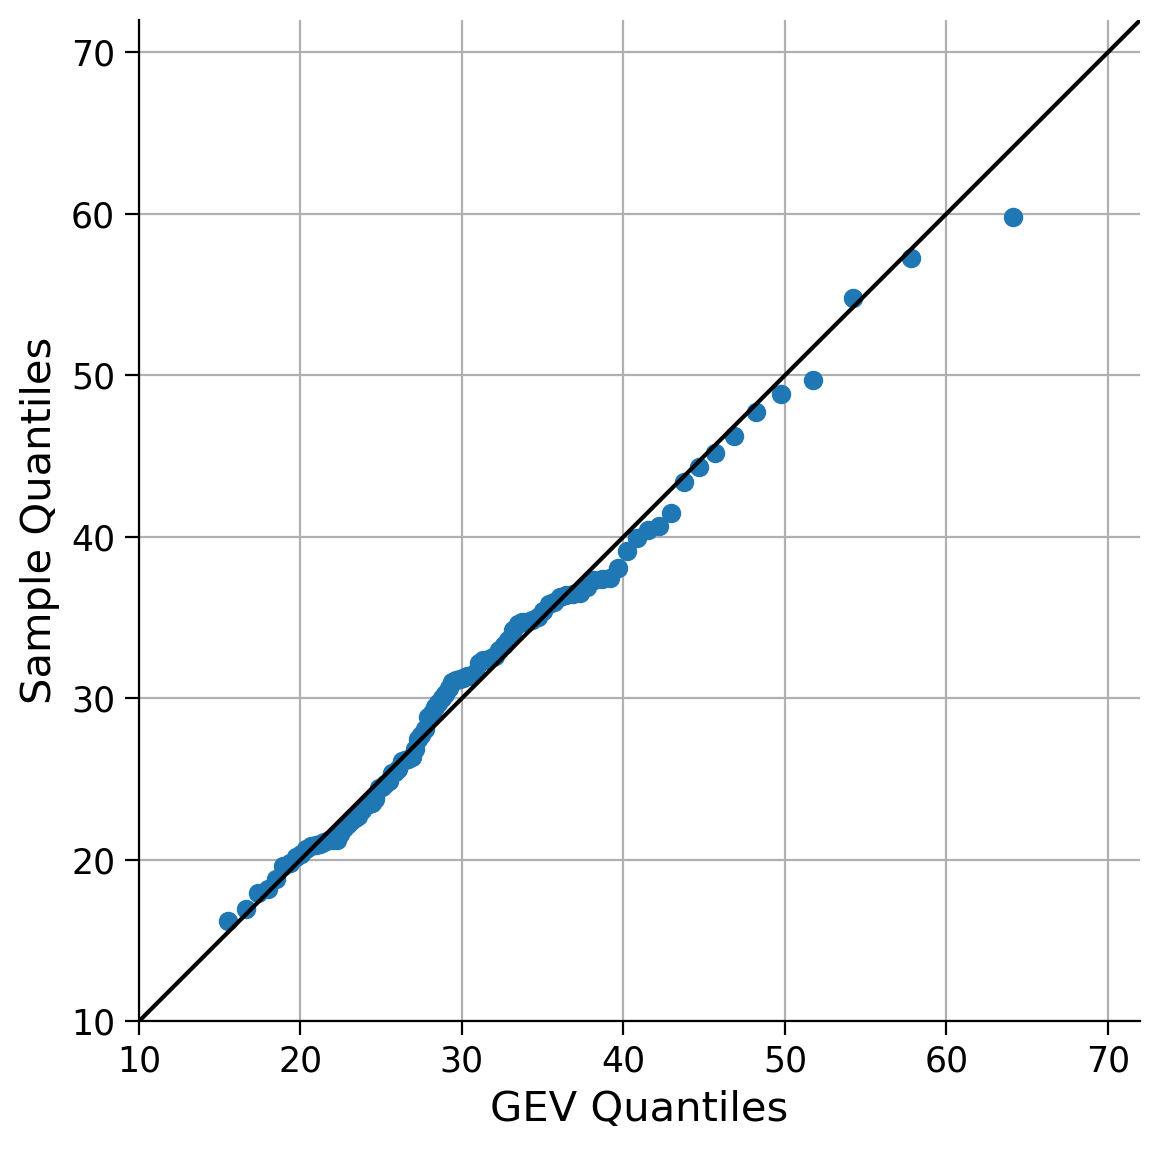

In [11]:
fig,ax=plt.subplots()
ax.plot(
    gev.ppf(x_r1, shape, loc=loc, scale=scale), 
    np.quantile(precipitation,x_r1),'o')

ax.plot(x_r100,x_r100,'k')

ax.set_xlim(10,72)
ax.set_ylim(10,72)

ax.set_xlabel('GEV Quantiles')
ax.set_ylabel('Sample Quantiles')

ax.grid(True)
ax.set_aspect('equal')

This looks much better! Apparently the GEV distribution is a better fit for the data than the Normal distribution

Now, let's generate a plot with two panels, each displaying a QQ plot. One panel will depict the QQ plot with a fit to the normal distribution, while the other panel will showcase the QQ plot with a fit to the GEV distribution. Similarly, we will create another plot with two panels: one displaying the histogram and PDF for the normal distribution, and the other displaying the histogram and PDF for the GEV distribution.

Lastly, we will overlay both PDFs (normal and GEV) on a single plot to visualize and compare the differences between them.

Text(0.5, 1.0, 'GEV distribution fit')

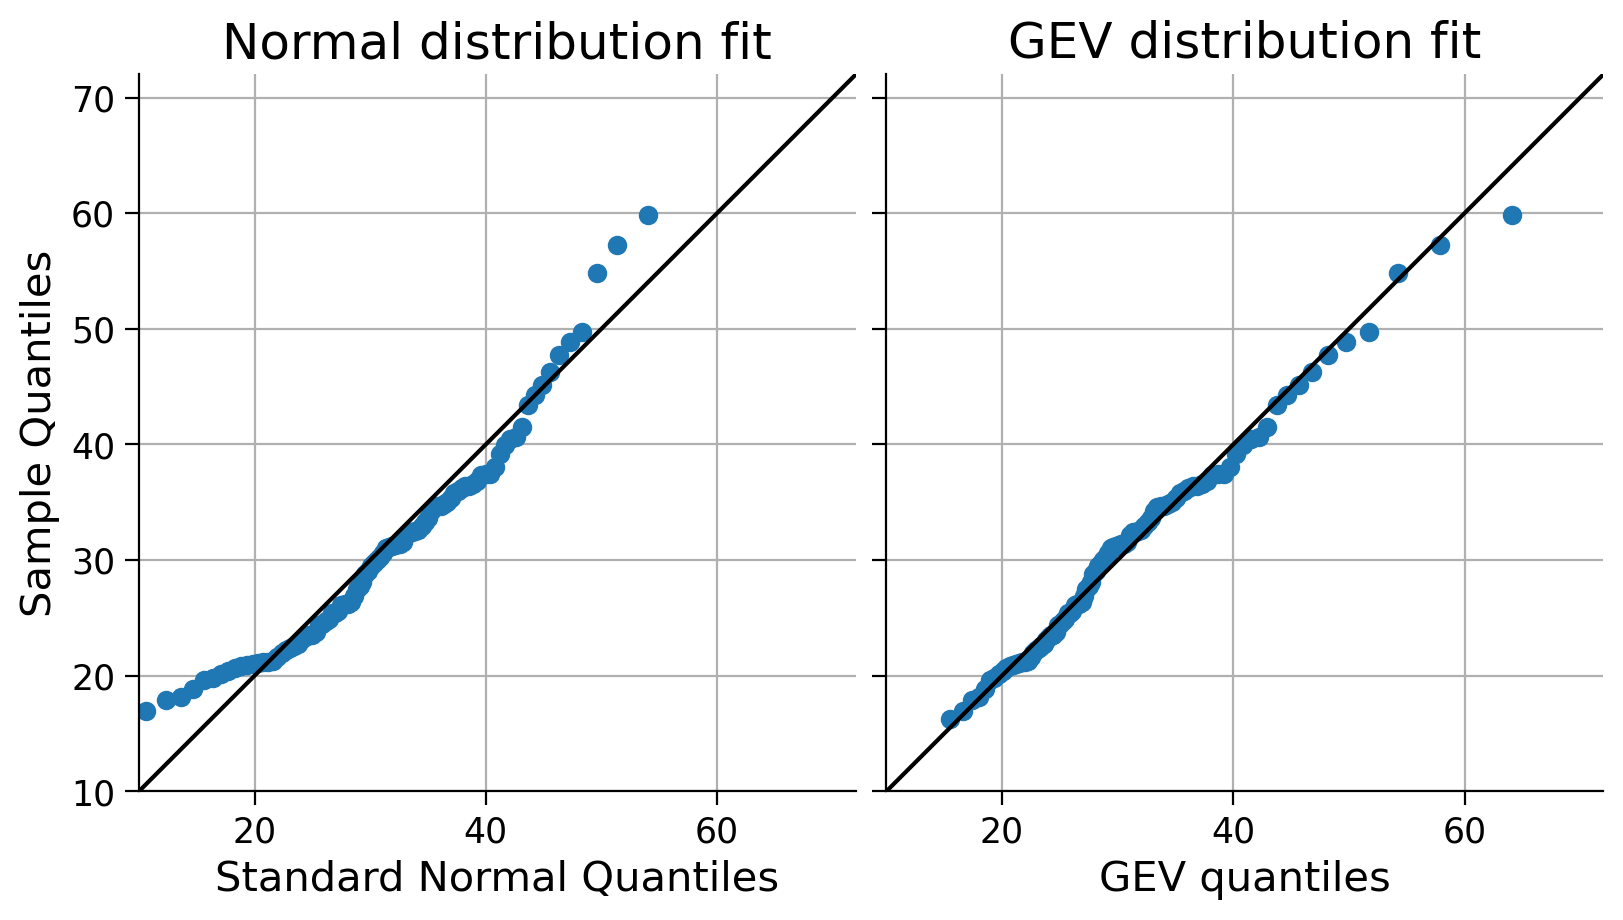

In [12]:
fig, ax = plt.subplots(1,2,sharey=True,sharex=True,constrained_layout=True)

# Normal
ax[0].plot(
    stats.norm.ppf(x_r1,precipitation.mean(), precipitation.std()),
    np.quantile(precipitation,x_r1),
    'o')
ax[0].plot(x_r100,x_r100,'k')

ax[0].set_xlabel('Standard Normal Quantiles')
ax[0].set_ylabel('Sample Quantiles')

ax[0].grid(True)

# GEV
ax[1].plot(
    gev.ppf(x_r1, shape, loc=loc, scale=scale), 
    np.quantile(precipitation,x_r1),
    'o')

ax[1].plot(x_r100,x_r100,'k')

ax[1].set_xlim(10,72)
ax[1].set_ylim(10,72)

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

ax[1].grid(True)
ax[1].set_xlabel('GEV quantiles')

ax[0].set_title('Normal distribution fit')
ax[1].set_title('GEV distribution fit')

Text(0.5, 1.0, 'GEV')

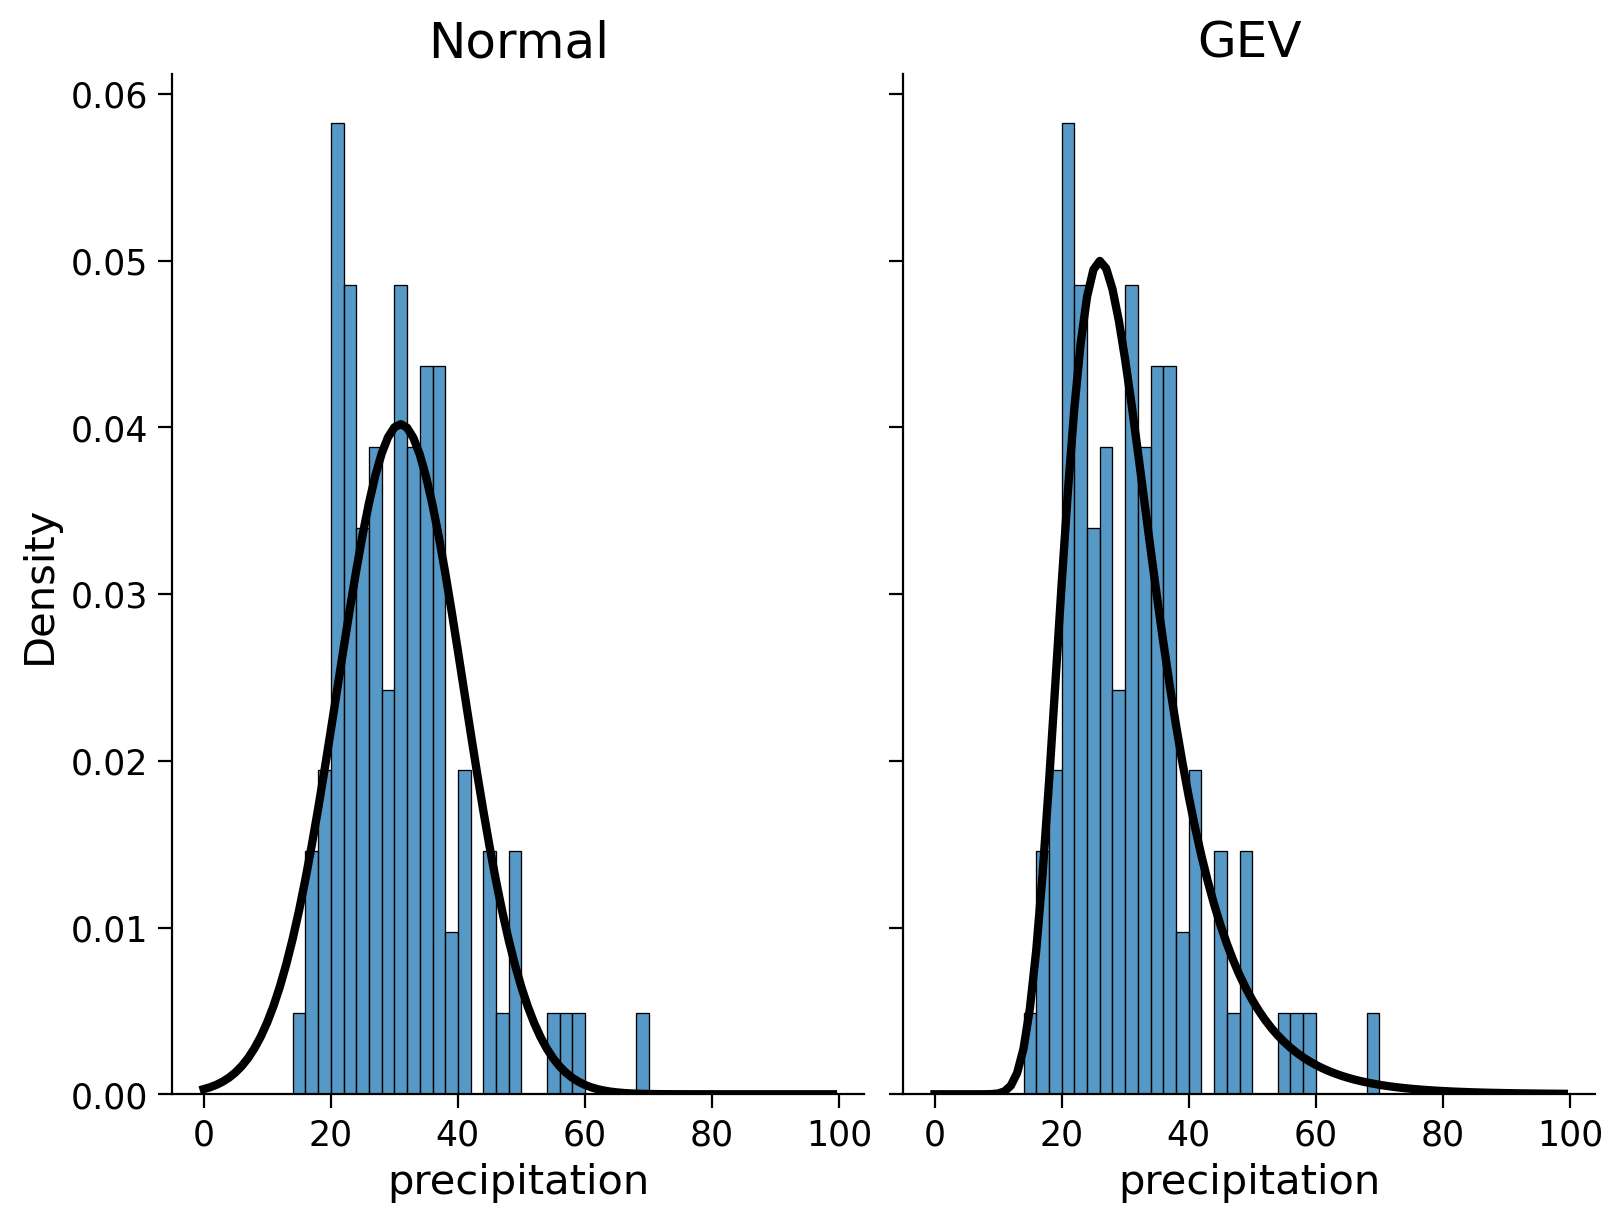

In [13]:
fig, ax = plt.subplots(1,2,sharex=True,sharey=True,constrained_layout=True)
sns.histplot(precipitation,ax=ax[0],bins=np.arange(0,80,2),stat='density')
sns.histplot(precipitation,ax=ax[1],bins=np.arange(0,80,2),stat='density')

ax[0].plot(x_r100,stats.norm.pdf(x_r100,precipitation.mean(),precipitation.std()),c='k',lw=3)
ax[1].plot(x_r100,gev.pdf(x_r100, shape, loc=loc, scale=scale),c='k',lw=3)


ax[0].set_title('Normal')
ax[1].set_title('GEV')

Text(0, 0.5, 'Density')

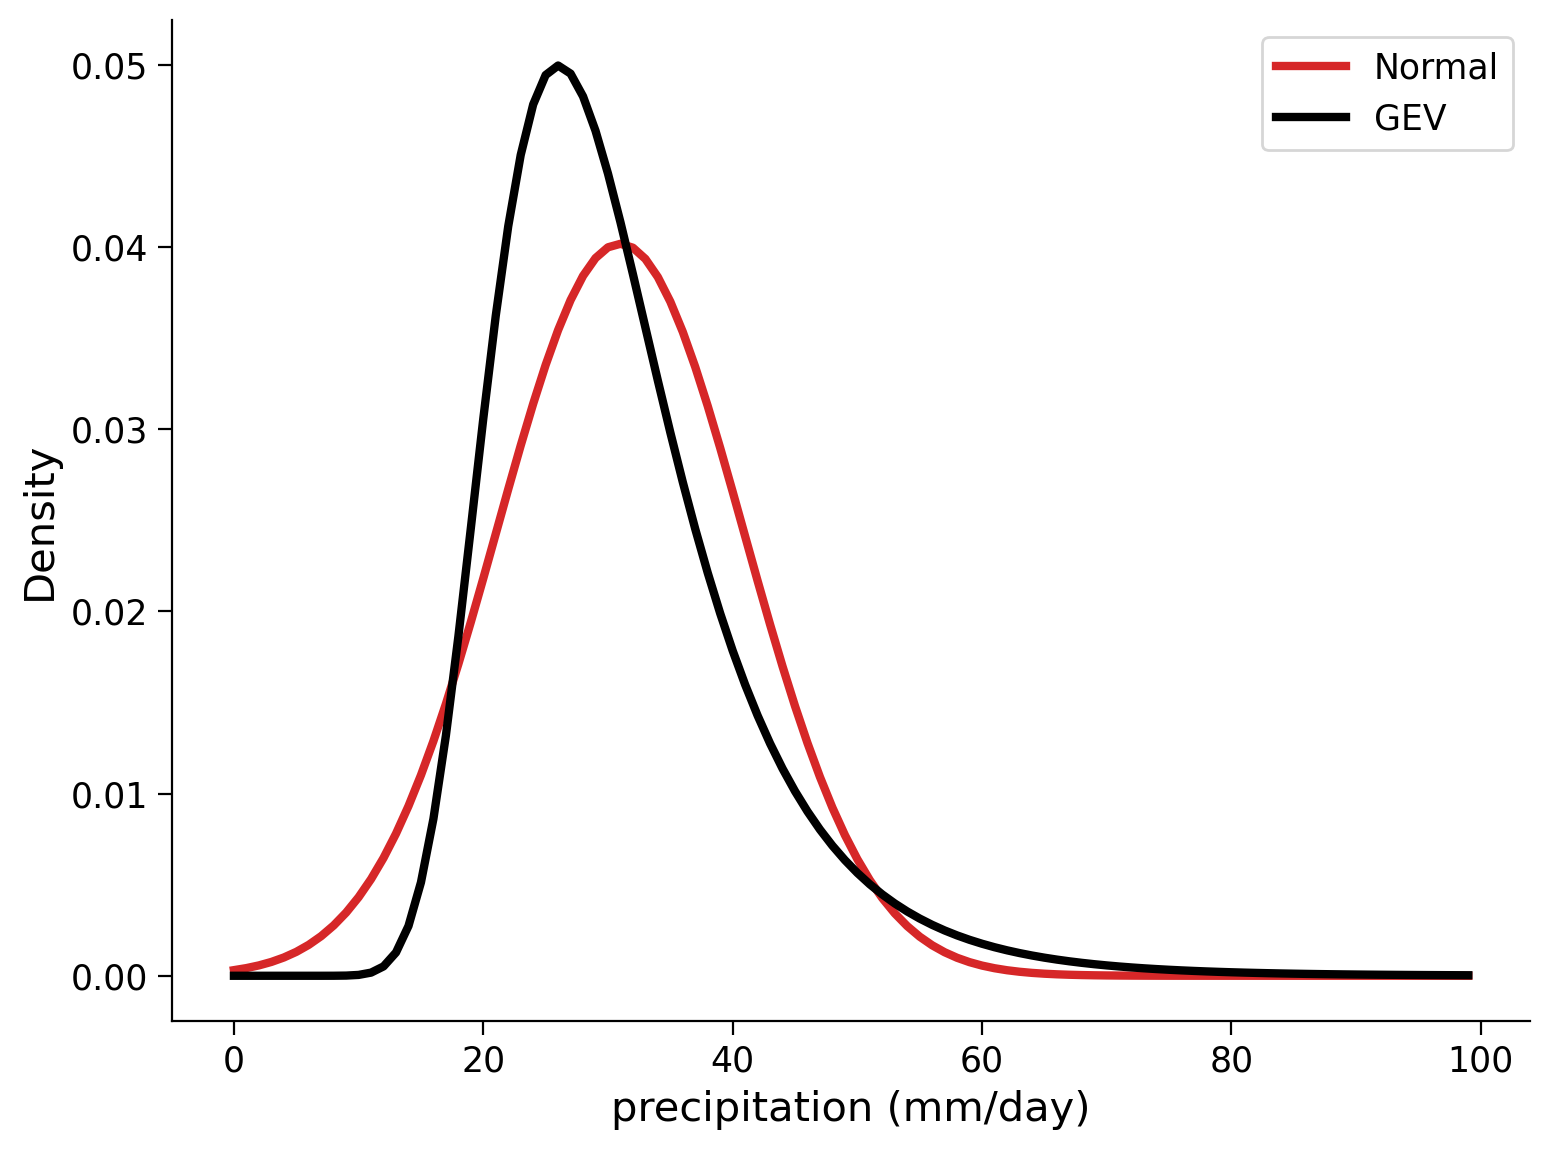

In [14]:
fig,ax=plt.subplots()
ax.plot(x_r100,stats.norm.pdf(x_r100,precipitation.mean(),precipitation.std()),c='C3',lw=3,label='Normal')
ax.plot(x_r100,gev.pdf(x_r100, shape, loc=loc, scale=scale),c='k',lw=3,label='GEV')
ax.legend()
ax.set_xlabel('precipitation (mm/day)')
ax.set_ylabel('Density')

How well do the two fitted distributions reflect the observed data and how do they compare to each other? 

## **Coding Exercise 1**

Parameters of the GEV distribution

Play a little with the gev.pdf function to get a better sense of how the parameters affect the shape of the pdf (distribution). Plot the distribution against the
‘x’ sequence and randomly change the parameters. What does each parameter do? 

Create three plots. In each, one of the parameters (location, scale, shape) is varied while the other two are held constant. The parameter values and ranges below may be a useful starting point.

In [15]:
loc = 26
scale = 7
shape = 0

range_loc = np.arange(20,40,4)
range_scale = np.arange(4,10,1)
range_shape = np.arange(-0.4,0.4+0.1,0.1)

# useful variable range for the chosen parameters
x_r80 = np.linspace(0,80,1000)


Text(0, 0.5, 'Density')

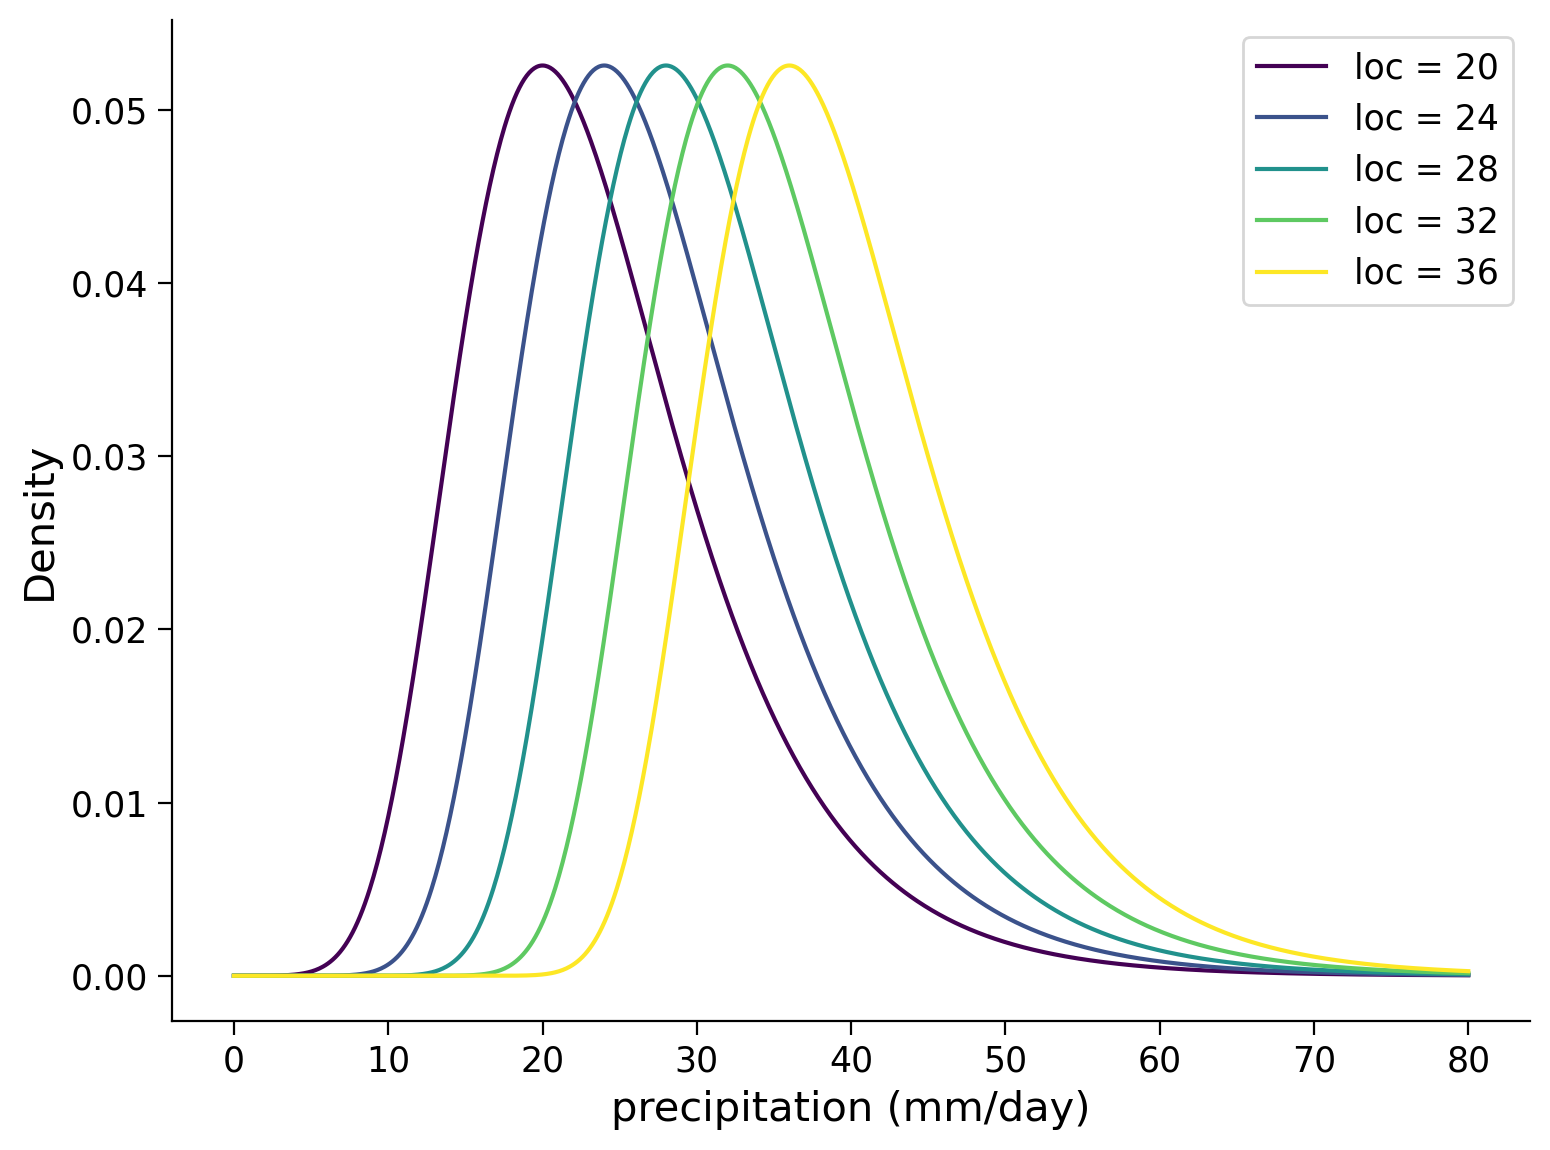

In [16]:
# to_remove solution

fig, ax = plt.subplots()
colors_loc = plt.cm.viridis(np.linspace(0,1,range_loc.size))

for idx,loci in enumerate(range_loc):
    ax.plot(x_r80,gev.pdf(x_r80, -shape, loc=loci, scale=scale),color=colors_loc[idx],label='loc = %i' % loci)

ax.legend()
ax.set_xlabel('precipitation (mm/day)')
ax.set_ylabel('Density')

Text(0, 0.5, 'Density')

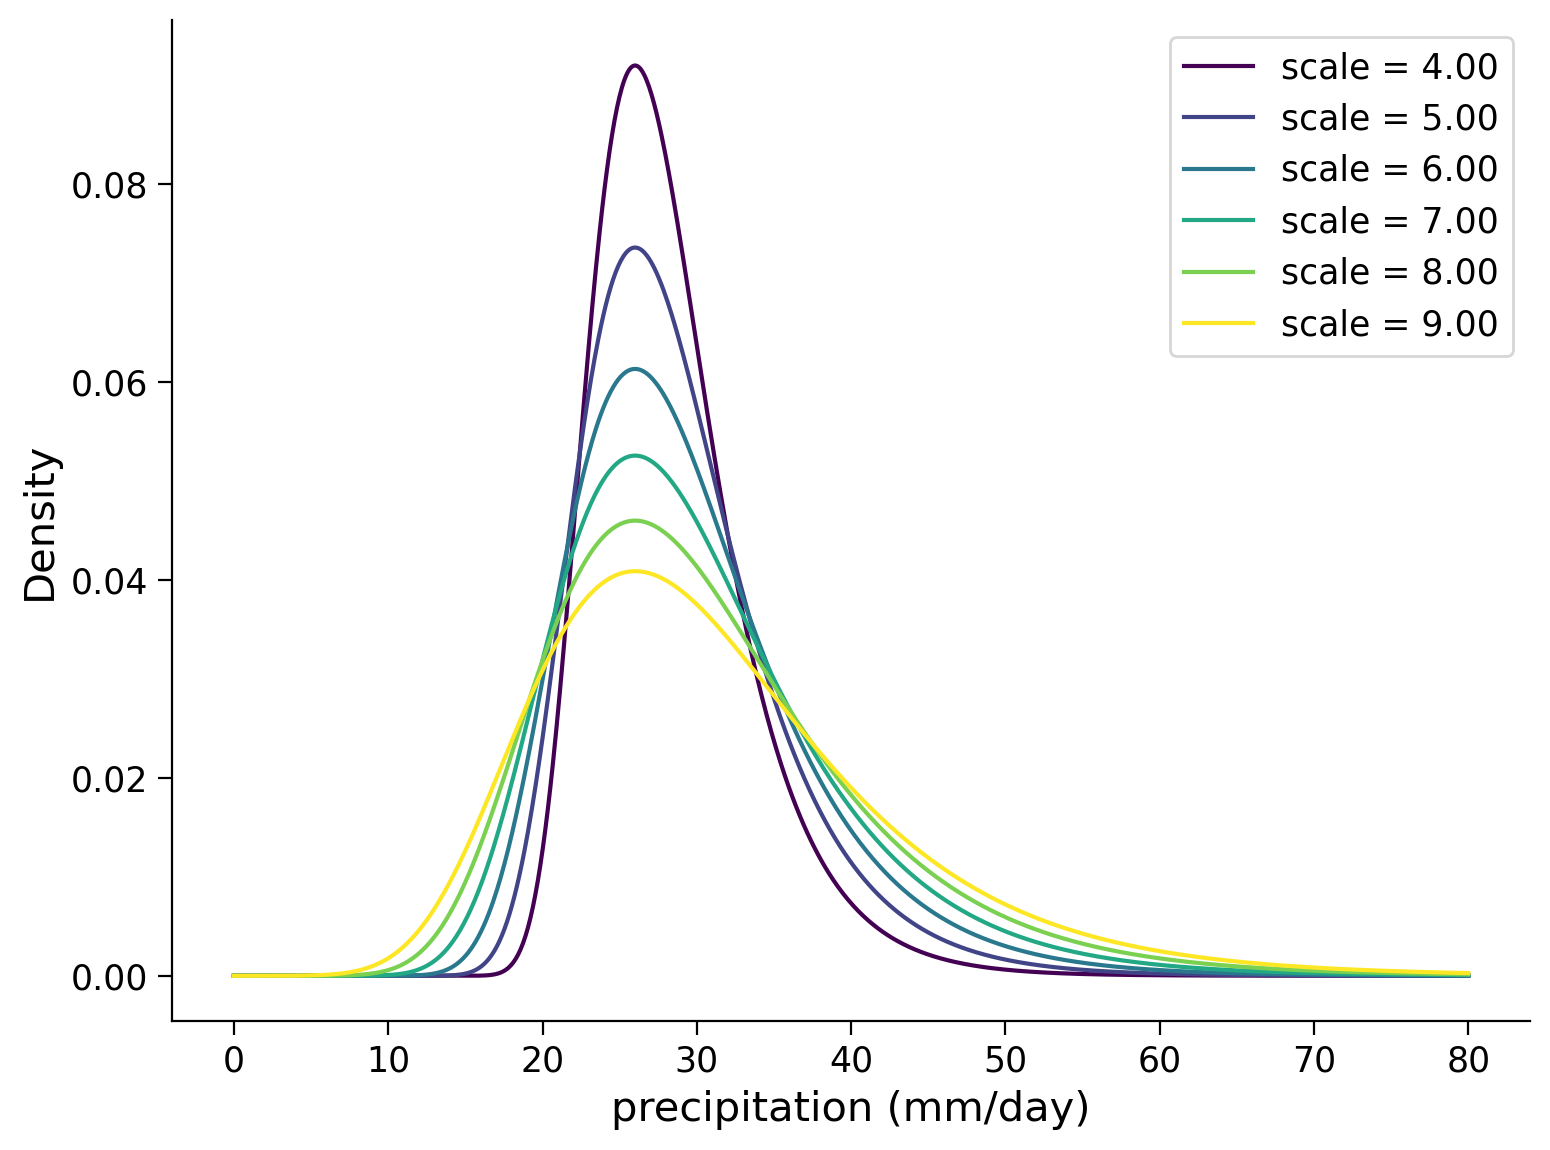

In [17]:
# to_remove solution
fig, ax = plt.subplots()
colors_range_scale = plt.cm.viridis(np.linspace(0,1,range_scale.size))

for idx,scalei in enumerate(range_scale):
    ax.plot(x_r80,gev.pdf(x_r80, -shape, loc=loc, scale=scalei),color=colors_range_scale[idx],label='scale = %.2f' % scalei)

ax.legend()
ax.set_xlabel('precipitation (mm/day)')
ax.set_ylabel('Density')


Text(0, 0.5, 'Density')

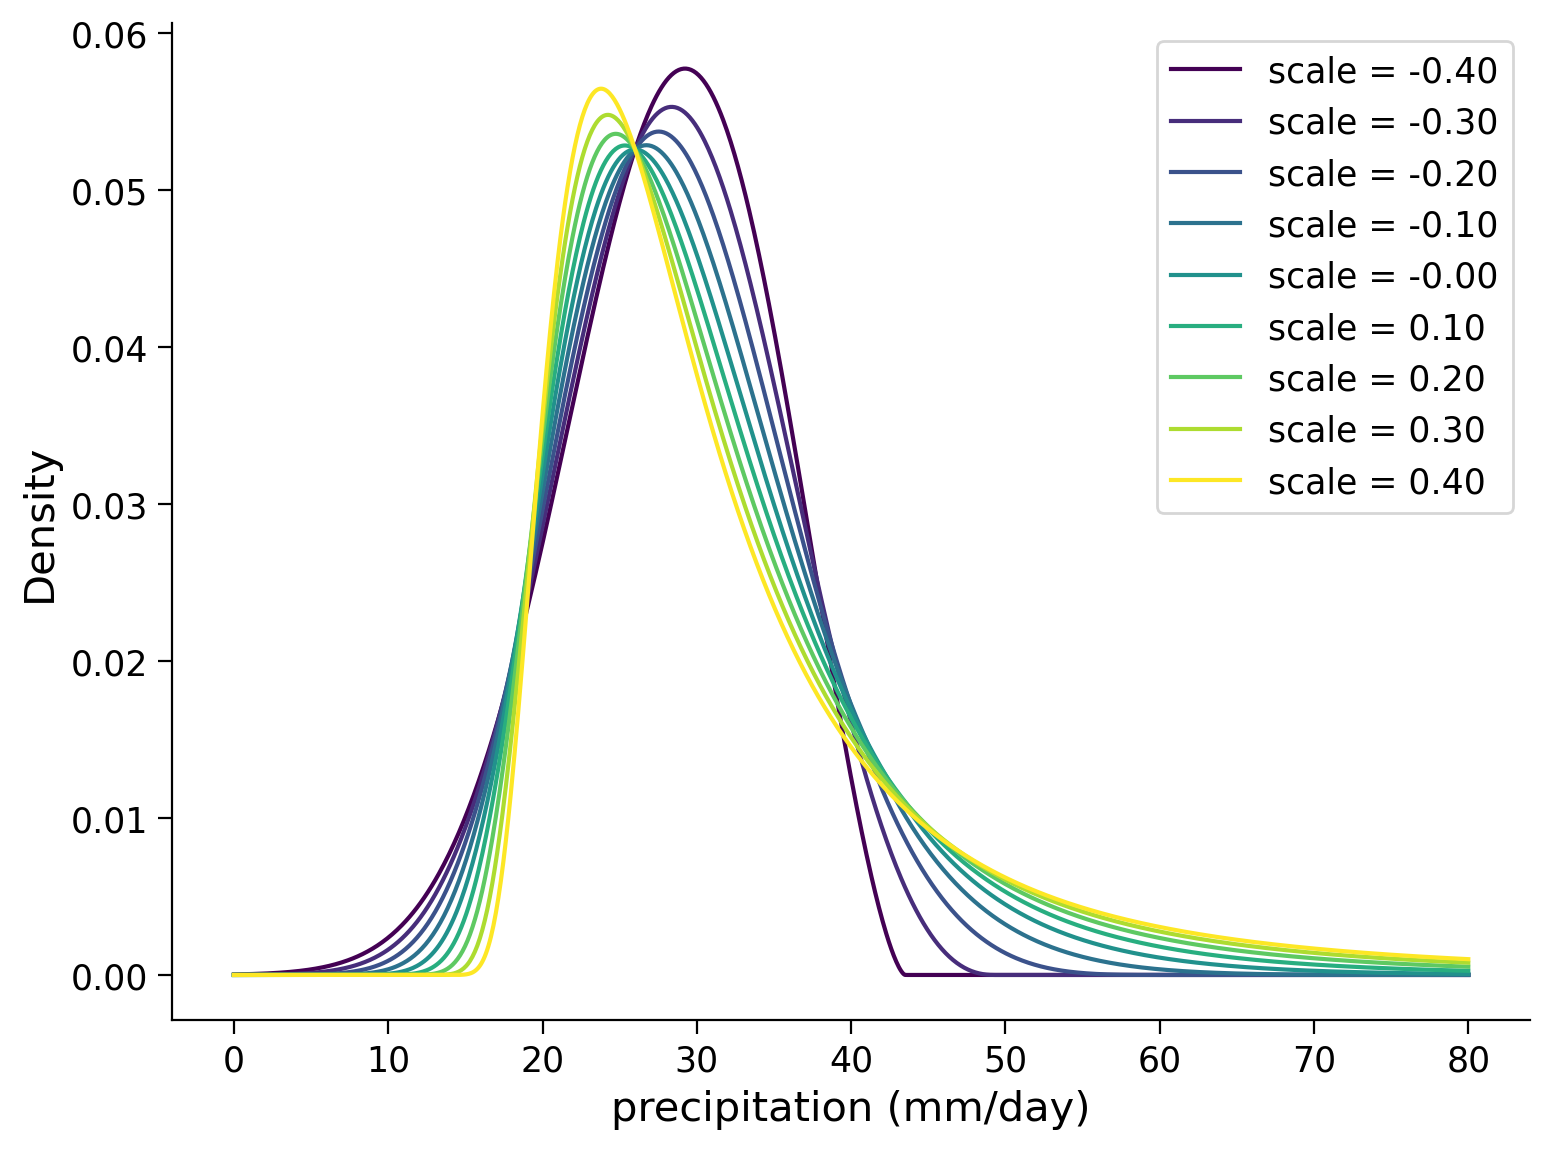

In [18]:
# to_remove solution
fig, ax = plt.subplots()
colors_range_shape = plt.cm.viridis(np.linspace(0,1,range_shape.size))

for idx,shapei in enumerate(range_shape):
    ax.plot(x_r80,gev.pdf(x_r80, -shapei, loc=loc, scale=scale),color=colors_range_shape[idx],label='scale = %.2f' % shapei)

ax.legend()
ax.set_xlabel('precipitation (mm/day)')
ax.set_ylabel('Density')

## **Questions 1**

1. How do the three parameters impact the shape of the distribution? What can you think of how these parameters affect extreme events?**

In [19]:
# to_remove explanation
"""
The three parameters of the Generalized Extreme Value (GEV) distribution—location, scale, and shape—each impact the shape of the distribution in unique ways:

Location parameter: This parameter shifts the distribution along the x-axis. In the context of extreme events, changing the location parameter shifts the entire distribution of extreme values, affecting the threshold at which extreme events are defined. For example, increasing the location parameter would imply that extreme events are occurring at higher values.

Scale parameter: The scale parameter influences the spread or width of the distribution. A higher scale parameter will widen the distribution, implying greater variability in extreme events, while a lower scale parameter will narrow the distribution, implying less variability. In the context of extreme events, a larger scale parameter would suggest a greater range of values that extreme events can take.

Shape parameter: This parameter is unique to the GEV distribution and impacts the tails of the distribution. It can make the tails of the distribution thinner or thicker, which in turn affects the skewness and kurtosis of the distribution. In the context of extreme events, a positive shape parameter results in a heavy-tailed distribution, implying a higher probability of very extreme events (far from the median), while a negative shape parameter results in a light-tailed distribution, implying a lower probability of such events.
"""

'\nThe three parameters of the Generalized Extreme Value (GEV) distribution—location, scale, and shape—each impact the shape of the distribution in unique ways:\n\nLocation parameter: This parameter shifts the distribution along the x-axis. In the context of extreme events, changing the location parameter shifts the entire distribution of extreme values, affecting the threshold at which extreme events are defined. For example, increasing the location parameter would imply that extreme events are occurring at higher values.\n\nScale parameter: The scale parameter influences the spread or width of the distribution. A higher scale parameter will widen the distribution, implying greater variability in extreme events, while a lower scale parameter will narrow the distribution, implying less variability. In the context of extreme events, a larger scale parameter would suggest a greater range of values that extreme events can take.\n\nShape parameter: This parameter is unique to the GEV distr

# **Summary**
In this tutorial, we explored the use of probability density functions for analyzing extreme climate events, with a focus on precipitation data that we played with in the previous two tutorials. We introduced the Generalized Extreme Value (GEV) distribution and discussed how the three parameters of the GEV distribution - location, scale, and shape - can influence the behavior of the distribution. We used scipy to estimate these parameters for our data, and to fit a GEV distribution. We compared the fit of the normal and GEV distributions to our data using Quantile-Quantile (QQ) plots and overlaid the probability density functions of both distributions for visual comparison. Finally, we manipulated the parameters of the GEV distribution to understand their effects on the shape of the distribution.